# Prova 1 (2°/2019)
## DPEE805 - Modelagem e Controle de Conversores
### Prof° Cassiano Rech | Acadêmico: Tiarles da Rocha Moralles Guterres

#### Informações gerais sobre este arquivo:
Este arquivo é um formato impresso de um ambiente em Python chamado Jupyter-notebook. Com o Jupyter-notebook você pode escrever código e documentá-lo simultaneamente, intercalando no que chamamos de células de código, em Python, e células de texto.

#### Um pouco sobre sintaxe:
Python, diferente de MATLAB, não existe um direcionamento específico para cálculos matriciais e modelagem. Porém, utilizando alguns repositórios (também chamados de módulos) podemos realizar quase todos os procedimentos feitos em MATLAB de forma bem simples. Python e seus pacotes são *open source*.

Os módulos utilizados neste notebook e importados na célula abaixo são:
* **pandas**: Para a leitura de arquivos ``.csv``.
* **matplotlib.pyplot**: Para a geração de figuras a partir de vetores.
* **numpy**: É a biblioteca numérica de Python, onde estão implementadas as estruturas e operações com vetores/matrizes.
* **scipy.signal**: Biblioteca para análise e reposta de sinais em vários domínios.

In [1]:
from pandas import read_csv
from matplotlib.pyplot import figure, plot, subplot, grid, legend, show, savefig
from numpy import array, identity, zeros, dot, ones, arange
from numpy.linalg import inv
from scipy.signal import StateSpace, lsim

<a id='step_function'></a>

Abaixo a função para simular o bloco de *step* do Simulink é declarada:

In [2]:
def step(t, t_step, y_inital, y_final, nome):
    ret = ones(t.size)
    
    yt_initial = t < t_step
    ret[yt_initial] = y_inital
    
    yt_final = t >= t_step
    ret[yt_final] = y_final
    
    plot(t, ret, label=nome)
    legend()
    show()

    return ret

Na célula abaixo, o arquivo com as ondas do PSIM é importado, algumas configurações são realizadas e é possível ver as primeiras e últimas amostras do arquivo:

In [3]:
df = read_csv('ericson_2_9.csv') # Aqui ocorre a importação do arquivo .csv

# E aqui a coluna que mostra o tempo instantâneo de cada amostra é setado como o indíce desta tabela
df = df.set_index('Time')

df

,iL1,iL2,vC1,vC2,V2,V3,V1
Time,,,,,,,
0.000001,0.048000,2.399970e-07,0.00036,1.498190e-09,0.40,1.000000e-02,1
0.000002,0.095999,1.199970e-06,0.00120,1.048300e-08,0.40,2.000000e-02,1
0.000003,0.143997,2.999910e-06,0.00240,3.144050e-08,0.40,3.000000e-02,1
0.000004,0.191994,6.239750e-06,0.00408,7.752990e-08,0.40,4.000000e-02,1
0.000005,0.239989,1.139940e-05,0.00624,1.654830e-07,0.40,5.000000e-02,1
...,...,...,...,...,...,...,...
0.049996,1.925880,4.239290e+00,48.29020,2.133180e+01,0.45,4.000000e-02,1
0.049997,1.925600,4.266240e+00,48.26700,2.133160e+01,0.45,3.000000e-02,1
0.049998,1.925340,4.293160e+00,48.24340,2.133180e+01,0.45,2.000000e-02,1


Abaixo cada uma das colunas de interesse são inseridas em variáveis diferentes para, mais tarde, compararmos com o modelo matemático calculado em espaço de estados:

In [4]:
iL1 = df['iL1']
vC1 = df['vC1']
iL2 = df['iL2']
vC2 = df['vC2']

E as correntes nos indutores e as tensões dos capacitores do **modelo físico** podem ser visualizados.

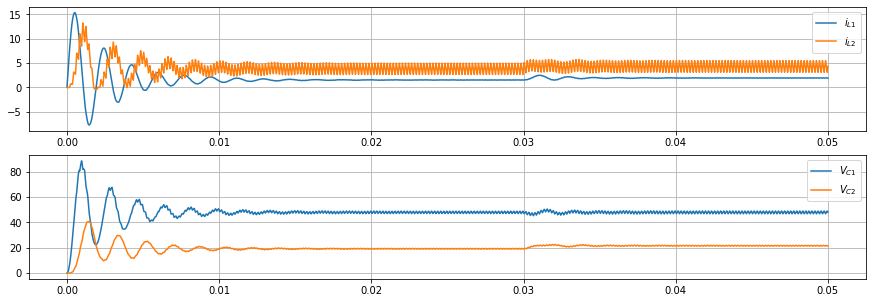

In [5]:
figure(figsize=(15, 5))
subplot(211)
plot(iL1, label='$i_{L1}$')
plot(iL2, label='$i_{L2}$')
legend()
grid()
subplot(212)
plot(vC1, label='$V_{C1}$')
plot(vC2, label='$V_{C2}$')
legend()
grid()
savefig('1_ondas_PSIM.png')
show()

#### Modelagem no espaço de estados

O tempo de simulação (``t_final``), a taxa de amostragem (``t_step``), os valores dos componentes (``L1``, ``L2``, ``Cap1``, ``Cap2`` e ``R``), a fonte de entrada (``Vin``), o *duty-cycle* (``D``), a pertubação de *duty-cycle* ($\hat{d}$ = ``d_f``) e a pertubação na fonte de entrada ($\hat{u}$ = ``v_f``) foram configurados abaixo:

In [6]:
t_step = 1e-6
t_final = .05

L1 = L2 = 1e-3
Cap1 = Cap2 = 100e-6
R = 5
Vin = 48
D = 0.4
d_f = .05
v_f = 0

E, como no arquivo ``aula_buckboost.m`` as matrizes para a modelagem são montadas:

In [7]:
K = array([[L1, 0,    0,    0], 
            [0, L2,    0,    0],
            [0,  0, Cap1,    0],
            [0,  0,    0, Cap2]])

**Primeira** Etapa do conversor (**ON**)

In [8]:
A1 = array([[0,  0, -1,    0],
            [0,  0,  1,   -1],
            [1, -1,  0,    0],
            [0,  1,  0, -1/R]])
B1 = array([1, 0, 0, 0])
C1 = identity(4)
E1 = zeros(4)

**Segunda** Etapa do conversor (**OFF**)

In [9]:
A2 = array([[0, 0, -1,   0],
            [0, 0, 0,   -1],
            [1, 0, 0,    0],
            [0, 1, 0, -1/R]])
B2 = array([1, 0, 0, 0])
C2 = identity(4)
E2 = zeros(4)

As matrizes médias:

In [10]:
A = D*A1 + (1-D)*A2;
B = D*B1 + (1-D)*B2;
C = D*C1 + (1-D)*C2;
E = D*E1 + (1-D)*E2;

Os valores em regime permanente. (Para a computação correta do produto escalar é utilizada a função ``dot``):

In [11]:
U = Vin
X = dot(dot(-inv(A), B), U)
Y = dot((dot(dot(-C, inv(A)), B)+E), U)

Matrizes padrão para representação do modelo CA em espaço de estados

In [12]:
Ap = dot(inv(K),A)
print(Ap)

[[    0.     0. -1000.     0.]
 [    0.     0.   400. -1000.]
 [10000. -4000.     0.     0.]
 [    0. 10000.     0. -2000.]]


Devido a sintaxe de Python as matrizes ``Bp`` e ``Ep``, que contém as componentes que multiplicam $\hat{d}$ e $\hat{u}$, necessitam ser transpostas:

In [13]:
Bp = array([dot(inv(K), B), 
            dot(inv(K), (dot((A1-A2),X) + dot((B1-B2), U)))]).transpose()
print(Bp)

[[  1000.      0.]
 [     0.  48000.]
 [     0. -38400.]
 [     0.      0.]]


In [14]:
Cp = C
print(Cp)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [15]:
Ep = array([E, dot((C1-C2),X) + dot((E1-E2),U)]).transpose()
print(Ep)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


Com as matrizes ``Ap``, ``Bp``, ``Cp``, ``Ep`` calculadas o modelo de espaço de estado é montado (a partir daqui o notebook assume o que o ``buckboost.mdl`` no Simulink faz)

In [16]:
ss_buckboost = StateSpace(Ap, Bp, Cp, Ep)

Um sinal de tempo (``t_in``) e os steps de entrada (``u`` e ``d``) são gerados utilizando a função [step](#step_function) criada.

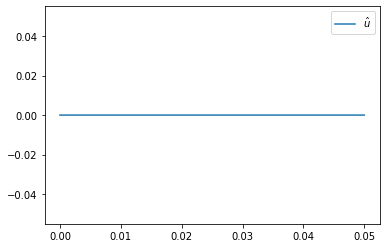

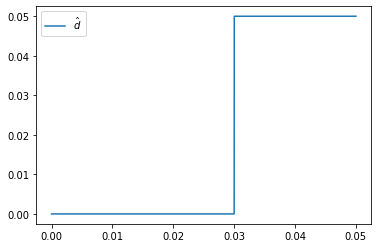

In [17]:
t_in = arange(0, t_final, t_step)

u = step(t_in, .03, 0, v_f, '$\hat{u}$')
d = step(t_in, .03, 0, d_f, '$\hat{d}$')

up = array([u, d]).transpose()

Nesse momento, com as entradas definidas e o modelo pronto podemos evolui-lo no espaço de estados utilizando a função ``lsim``:

In [18]:
t, y1, _ = lsim(ss_buckboost, up, T=t_in)

E a resposta do modelo pertubado é somado com a saída ``Y``:

In [19]:
iL1_ss = y1[:,0] + Y[0]
iL2_ss = y1[:,1] + Y[1]

vC1_ss = y1[:,2] + Y[2]
vC2_ss = y1[:,3] + Y[3]

A figura abaixo mostra o modelo obtido para as medidas de interesse:

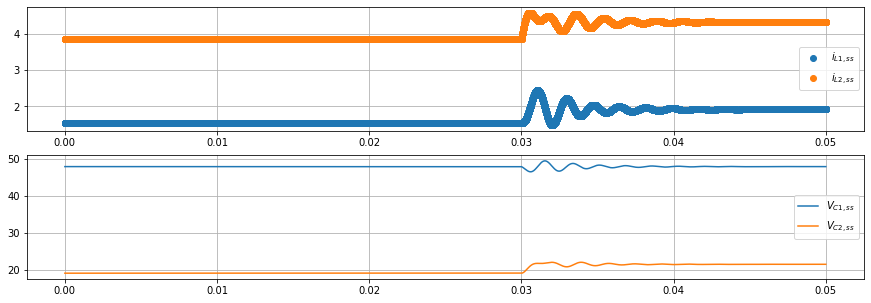

In [20]:
figure(figsize=(15, 5))

subplot(211)
plot(t, iL1_ss, 'o', label='$i_{L1, ss}$')
plot(t, iL2_ss, 'o', label='$i_{L2, ss}$')
legend()
grid()

subplot(212)
plot(t, vC1_ss, label='$V_{C1, ss}$')
plot(t, vC2_ss, label='$V_{C2, ss}$')
legend()
grid()
savefig('2_ondas_Matematico.png')
show()

E por fim, o modelo de espaço de estados é comparado com o modelo físico:

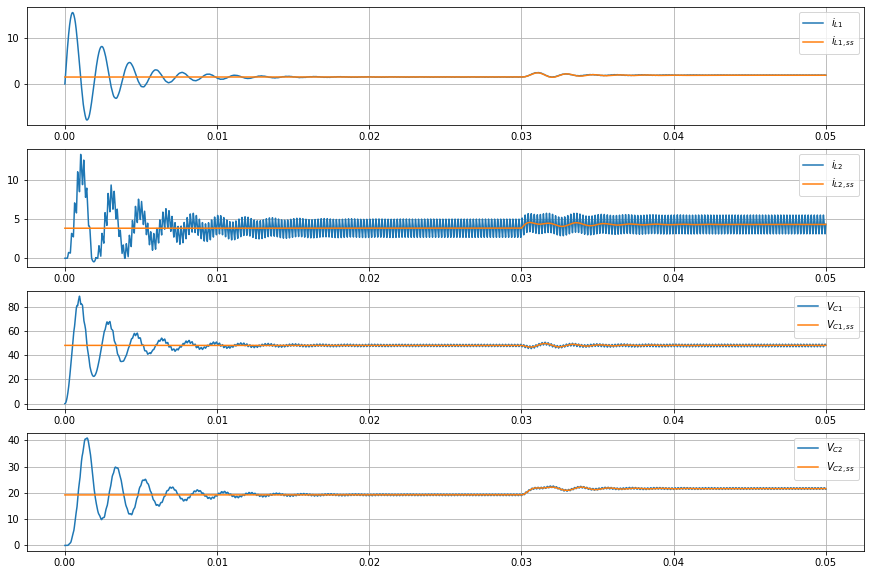

In [21]:
figure(figsize=(15, 10))

subplot(411)
plot(df.index, iL1, label='$i_{L1}$')
plot(t, iL1_ss, label='$i_{L1, ss}$')
legend()
grid()

subplot(412)
plot(df.index, iL2, label='$i_{L2}$')
plot(t, iL2_ss, label='$i_{L2, ss}$')

legend()
grid()

subplot(413)
plot(df.index, vC1, label='$V_{C1}$')
plot(t, vC1_ss, label='$V_{C1, ss}$')
legend()
grid()

subplot(414)
plot(df.index, vC2, label='$V_{C2}$')
plot(t, vC2_ss, label='$V_{C2, ss}$')
legend()
grid()

savefig('3_comparacao_modelos.png')

show()

## Geração da Função de Transferência

Devido algumas diferenças toleráveis na computação de valores muito grandes os arrays com numeradores e o denominadores gerados foram **arredondados para 6 casas decimais**. Isto deixa mais clara a representação da função de transferência.

In [58]:
from scipy.signal import ss2tf
from control import tf
from numpy import around

In [59]:
(num, den) = ss2tf(Ap,Bp,Cp,Ep,0)

n_of_decimals = 6
num = around(num, n_of_decimals)
den = around(den, n_of_decimals)

Gi_vg = tf(num[0], den)
Gv_vg = tf(num[1], den)

In [60]:
print(Gi_vg)
print(Gv_vg)


    1000 s^3 + 2e+06 s^2 + 1.16e+10 s + 3.2e+12
--------------------------------------------------
s^4 + 2000 s^3 + 2.16e+07 s^2 + 2.32e+10 s + 1e+14


                  4e+09 s + 8e+12
--------------------------------------------------
s^4 + 2000 s^3 + 2.16e+07 s^2 + 2.32e+10 s + 1e+14



In [61]:
(num, den) = ss2tf(Ap,Bp,Cp,Ep,1)

num = around(num, n_of_decimals)
den = around(den, n_of_decimals)

Gi_vg = tf(num[0], den)
Gv_vg = tf(num[1], den)

In [62]:
print(Gi_vg)
print(Gv_vg)


      3.84e+07 s^2 + 2.688e+11 s + 7.68e+14
--------------------------------------------------
s^4 + 2000 s^3 + 2.16e+07 s^2 + 2.32e+10 s + 1e+14


4.8e+04 s^3 + 8.064e+07 s^2 + 4.493e+11 s + 9.6e+14
---------------------------------------------------
s^4 + 2000 s^3 + 2.16e+07 s^2 + 2.32e+10 s + 1e+14

